In [1]:
from matplotlib import pyplot as plt
from PIL import Image as im
from PIL import ImageFilter
import numpy as np
import random
import math
import os

In [2]:
#
# Shorthand:
#   "pd_" as a variable prefix means "partial derivative"
#   "d_" as a variable prefix means "derivative"
#   "_wrt_" is shorthand for "with respect to"
#   "w_ho" and "w_ih" are the index of weights from hidden to output layer neurons and input to hidden layer neurons respectively
#
# Comment references:
#
# [1] Wikipedia article on Backpropagation
#   http://en.wikipedia.org/wiki/Backpropagation#Finding_the_derivative_of_the_error
# [2] Neural Networks for Machine Learning course on Coursera by Geoffrey Hinton
#   https://class.coursera.org/neuralnets-2012-001/lecture/39
# [3] The Back Propagation Algorithm
#   https://www4.rgu.ac.uk/files/chapter3%20-%20bp.pdf

class NeuralNetwork:

    def __init__(self, num_inputs, num_hidden, num_outputs, hidden_layer_weights = None, hidden_layer_bias = None, output_layer_weights = None, output_layer_bias = None):
        self.num_inputs = num_inputs

        self.hidden_layer = NeuronLayer(num_hidden, hidden_layer_bias)
        self.output_layer = NeuronLayer(num_outputs, output_layer_bias)

        self.init_weights_from_inputs_to_hidden_layer_neurons(hidden_layer_weights)
        self.init_weights_from_hidden_layer_neurons_to_output_layer_neurons(output_layer_weights)

    def init_weights_from_inputs_to_hidden_layer_neurons(self, hidden_layer_weights):
        weight_num = 0
        for h in range(len(self.hidden_layer.neurons)):
            for i in range(self.num_inputs):
                if not hidden_layer_weights:
                    self.hidden_layer.neurons[h].weights.append(random.random())
                else:
                    self.hidden_layer.neurons[h].weights.append(hidden_layer_weights[weight_num])
                weight_num += 1

    def init_weights_from_hidden_layer_neurons_to_output_layer_neurons(self, output_layer_weights):
        weight_num = 0
        for o in range(len(self.output_layer.neurons)):
            for h in range(len(self.hidden_layer.neurons)):
                if not output_layer_weights:
                    self.output_layer.neurons[o].weights.append(random.random())
                else:
                    self.output_layer.neurons[o].weights.append(output_layer_weights[weight_num])
                weight_num += 1

    def inspect(self):
        print('------')
        print('* Inputs: {}'.format(self.num_inputs))
        print('------')
        print('Hidden Layer')
        self.hidden_layer.inspect()
        print('------')
        print('* Output Layer')
        self.output_layer.inspect()
        print('------')

    def feed_forward(self, inputs):
        hidden_layer_outputs = self.hidden_layer.feed_forward(inputs)
        return self.output_layer.feed_forward(hidden_layer_outputs)

    # Uses online learning, ie updating the weights after each training case
    def train(self, training_inputs, training_outputs):
        self.feed_forward(training_inputs)

        # 1. Output neuron deltas
        pd_errors_wrt_output_neuron_total_net_input = [0] * len(self.output_layer.neurons)
        for o in range(len(self.output_layer.neurons)):

            # ∂E/∂zⱼ
            pd_errors_wrt_output_neuron_total_net_input[o] = self.output_layer.neurons[o].calculate_pd_error_wrt_total_net_input(training_outputs[o])

        # 2. Hidden neuron deltas
        pd_errors_wrt_hidden_neuron_total_net_input = [0] * len(self.hidden_layer.neurons)
        for h in range(len(self.hidden_layer.neurons)):

            # We need to calculate the derivative of the error with respect to the output of each hidden layer neuron
            # dE/dyⱼ = Σ ∂E/∂zⱼ * ∂z/∂yⱼ = Σ ∂E/∂zⱼ * wᵢⱼ
            d_error_wrt_hidden_neuron_output = 0
            for o in range(len(self.output_layer.neurons)):
                d_error_wrt_hidden_neuron_output += pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].weights[h]

            # ∂E/∂zⱼ = dE/dyⱼ * ∂zⱼ/∂
            pd_errors_wrt_hidden_neuron_total_net_input[h] = d_error_wrt_hidden_neuron_output * self.hidden_layer.neurons[h].calculate_pd_total_net_input_wrt_input()

        # 3. Update output neuron weights
        for o in range(len(self.output_layer.neurons)):
            for w_ho in range(len(self.output_layer.neurons[o].weights)):

                # ∂Eⱼ/∂wᵢⱼ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢⱼ
                pd_error_wrt_weight = pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].calculate_pd_total_net_input_wrt_weight(w_ho)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.output_layer.neurons[o].weights[w_ho] -= LEARNING_RATE * pd_error_wrt_weight

        # 4. Update hidden neuron weights
        for h in range(len(self.hidden_layer.neurons)):
            for w_ih in range(len(self.hidden_layer.neurons[h].weights)):

                # ∂Eⱼ/∂wᵢ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢ
                pd_error_wrt_weight = pd_errors_wrt_hidden_neuron_total_net_input[h] * self.hidden_layer.neurons[h].calculate_pd_total_net_input_wrt_weight(w_ih)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.hidden_layer.neurons[h].weights[w_ih] -= LEARNING_RATE * pd_error_wrt_weight

    def calculate_total_error(self, training_sets):
        total_error = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                total_error += self.output_layer.neurons[o].calculate_error(training_outputs[o])
        return total_error

class NeuronLayer:
    def __init__(self, num_neurons, bias):

        # Every neuron in a layer shares the same bias
        self.bias = bias if bias else random.random()

        self.neurons = []
        for i in range(num_neurons):
            self.neurons.append(Neuron(self.bias))

    def inspect(self):
        print('Neurons:', len(self.neurons))
        for n in range(len(self.neurons)):
            print(' Neuron', n)
            for w in range(len(self.neurons[n].weights)):
                print('  Weight:', self.neurons[n].weights[w])
            print('  Bias:', self.bias)

    def feed_forward(self, inputs):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.calculate_output(inputs))
        return outputs

    def get_outputs(self):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.output)
        return outputs

class Neuron:
    def __init__(self, bias):
        self.bias = bias
        self.weights = []

    def calculate_output(self, inputs):
        self.inputs = inputs
        self.output = self.squash(self.calculate_total_net_input())
        return self.output

    def calculate_total_net_input(self):
        total = 0
        for i in range(len(self.inputs)):
            total += self.inputs[i] * self.weights[i]
        return total + self.bias

    # Apply the logistic function to squash the output of the neuron
    # The result is sometimes referred to as 'net' [2] or 'net' [1]
    def squash(self, total_net_input):
        return 1 / (1 + math.exp(-total_net_input))

    # Determine how much the neuron's total input has to change to move closer to the expected output
    #
    # Now that we have the partial derivative of the error with respect to the output (∂E/∂yⱼ) and
    # the derivative of the output with respect to the total net input (dyⱼ/dzⱼ) we can calculate
    # the partial derivative of the error with respect to the total net input.
    # This value is also known as the delta (δ) [1]
    # δ = ∂E/∂zⱼ = ∂E/∂yⱼ * dyⱼ/dzⱼ
    #
    def calculate_pd_error_wrt_total_net_input(self, target_output):
        return self.calculate_pd_error_wrt_output(target_output) * self.calculate_pd_total_net_input_wrt_input();

    # The error for each neuron is calculated by the Mean Square Error method:
    def calculate_error(self, target_output):
        return 0.5 * (target_output - self.output) ** 2

    # The partial derivate of the error with respect to actual output then is calculated by:
    # = 2 * 0.5 * (target output - actual output) ^ (2 - 1) * -1
    # = -(target output - actual output)
    #
    # The Wikipedia article on backpropagation [1] simplifies to the following, but most other learning material does not [2]
    # = actual output - target output
    #
    # Alternative, you can use (target - output), but then need to add it during backpropagation [3]
    #
    # Note that the actual output of the output neuron is often written as yⱼ and target output as tⱼ so:
    # = ∂E/∂yⱼ = -(tⱼ - yⱼ)
    def calculate_pd_error_wrt_output(self, target_output):
        return -(target_output - self.output)

    # The total net input into the neuron is squashed using logistic function to calculate the neuron's output:
    # yⱼ = φ = 1 / (1 + e^(-zⱼ))
    # Note that where ⱼ represents the output of the neurons in whatever layer we're looking at and ᵢ represents the layer below it
    #
    # The derivative (not partial derivative since there is only one variable) of the output then is:
    # dyⱼ/dzⱼ = yⱼ * (1 - yⱼ)
    def calculate_pd_total_net_input_wrt_input(self):
        return self.output * (1 - self.output)

    # The total net input is the weighted sum of all the inputs to the neuron and their respective weights:
    # = zⱼ = netⱼ = x₁w₁ + x₂w₂ ...
    #
    # The partial derivative of the total net input with respective to a given weight (with everything else held constant) then is:
    # = ∂zⱼ/∂wᵢ = some constant + 1 * xᵢw₁^(1-0) + some constant ... = xᵢ
    def calculate_pd_total_net_input_wrt_weight(self, index):
        return self.inputs[index]

In [3]:
def convolution(img, filt_size):
    km = np.random.randint(-3, 4, (filt_size, filt_size))
    k = ImageFilter.Kernel(
        size=km.shape,
        kernel=tuple(km.flatten()),
        scale=np.sum(km),
        offset=0
        )
    
    return img.filter(k)

In [4]:
def maxPooling(img, stride):
    pixels = np.array(img)
    downSampledPixels = pixels[::stride,::stride]
    return im.fromarray(downSampledPixels, 'L')

In [5]:
def prepro2(img, filterCount, filterSize, stride):
    
    images = []
    for i in range(len(img)):
        for j in range(filterCount):
            conv = convolution(img[i], filterSize)
            pool = maxPooling(conv, stride)
            images.append(pool)
    
    return images

In [6]:
def flatting(images):
    imgArrays = []
    for i in range(len(images)):
        pixels = np.array(images[i])
        imgArrays.append(pixels.flatten())
    
    return imgArrays

In [7]:
def prepro1(roundCount, img, label, filterCount, filterSize, stride):
    images = [img]
    for i in range(roundCount):
        images = prepro2(images, filterCount, filterSize, stride)
    
    imgArrays = flatting(images)
    labels = [[label]]*len(imgArrays)
    data = zip(imgArrays, labels)
    
    return data

In [8]:
def getData(root):
    os.chdir(root)
    labels = os.listdir()

    data = {}
    for label in labels:
        data[label] = []
        imgNames = os.listdir(label)
        for image in imgNames:
            data[label].append(im.open(label + '/' + image).convert('L'))

    return data

In [9]:
import time
from tqdm import tqdm

In [10]:
def prepro(data, roundCount, filterCount, filterSize, stride):
    preprocessedData = []
    i = 0
    for label in data.keys():
        i += 1
        print('* '*i)
        for j in tqdm(range(len(data[label]))):
            imgArs = prepro1(roundCount=roundCount, img=data[label][j], label=i*25, filterCount=filterCount, filterSize=filterSize, stride=stride)
            preprocessedData += list(imgArs)
            
    return preprocessedData

In [11]:
data = getData('clf')

In [36]:
preprocessedData = prepro(data, roundCount=4, filterCount=5, filterSize=3, stride=2)

* 




  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

 18%|███████████████                                                                    | 2/11 [00:00<00:00, 14.75it/s]

 36%|██████████████████████████████▏                                                    | 4/11 [00:00<00:00, 15.08it/s]

 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:00<00:00, 15.25it/s]

 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [00:00<00:00, 15.27it/s]

 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [00:00<00:00, 15.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.19it/s]

* * 




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:00, 15.79it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00, 15.72it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00, 15.41it/s]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:00<00:00, 15.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.07it/s]

* * * 




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:00, 13.83it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00, 13.80it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00, 10.90it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:00<00:00, 11.33it/s]

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:00<00:00, 11.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04it/s]

* * * * 




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:00, 12.69it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00, 12.62it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00, 12.74it/s]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:00<00:00, 13.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.35it/s]

* * * * * 




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:00, 12.53it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00, 12.51it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00, 12.26it/s]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:00<00:00, 12.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37it/s]

* * * * * * 




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:00, 12.15it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00, 12.09it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00, 12.38it/s]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:00<00:00, 12.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.58it/s]

* * * * * * * 




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:00, 11.66it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00, 12.37it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00, 12.90it/s]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:00<00:00, 13.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.20it/s]

* * * * * * * * 




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:00, 15.67it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00, 15.67it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00, 15.41it/s]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:00<00:00, 14.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.73it/s]

* * * * * * * * * 




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:00, 12.46it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00, 12.96it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00, 12.71it/s]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:00<00:00, 12.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26it/s]

* * * * * * * * * * 




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:00, 13.83it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00, 13.33it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00, 13.26it/s]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:00<00:00, 13.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.23it/s]

In [37]:
preprocessedData = list(preprocessedData)

In [40]:
preprocessedData[0][0]

array([190, 201, 226,   0], dtype=uint8)

In [41]:
import pandas as pd

df = pd.DataFrame([190, 201, 226,   0, 25])
df = df.transpose()

for row in preprocessedData:
    df2 = pd.DataFrame(list(row[0]) + row[1])
    df = df.append(df2.transpose(), ignore_index=True)

In [42]:
corre = df.corr()

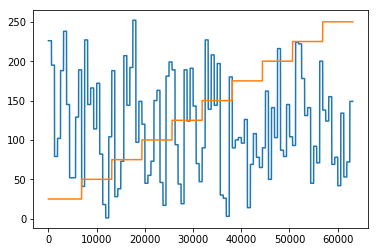

In [46]:
a = [i for i in range(len(df))]
df[4] = df[4]
plt.plot(a, df[2], df[4])

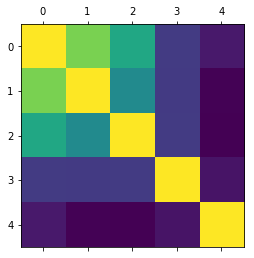

In [47]:
plt.matshow(corre)
plt.show()

In [19]:
sonuc1 = prepro1(roundCount=3, img=data['frog'][0], label=1, filterCount=5, filterSize=3, stride=2)

In [20]:
sonuc1 = map(lambda x: list(x), sonuc1)

In [21]:
sonuc1 = list(sonuc1)

In [22]:
sonuc2 = prepro1(roundCount=3, img=data['ship'][0], label=2, filterCount=5, filterSize=3, stride=2)

In [23]:
sonuc2 = map(lambda x: list(x), sonuc2)

In [24]:
sonuc2 = list(sonuc2)

In [25]:
sonuc = sonuc1 + sonuc2

In [26]:
len(sonuc)

250

In [27]:
sonuc[0]

[array([102, 106, 115,  97, 102,  41, 195,  57,  90,  50,   0,  93,  99,
        244,   0,  86], dtype=uint8), [1]]

In [48]:
##### XOR example:

LEARNING_RATE = 0.5
training_sets = preprocessedData

nn = NeuralNetwork(len(training_sets[0][0]), len(training_sets[0][0]), 1)
for i in tqdm(range(1000)):
    training_inputs, training_outputs = random.choice(training_sets)
    nn.train(training_inputs, training_outputs)
    print(i, nn.calculate_total_error(training_sets))



  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

0 743570625.0324908




  0%|                                                                               | 1/1000 [00:04<1:20:12,  4.82s/it]

1 743570625.0324908




  0%|▏                                                                              | 2/1000 [00:08<1:15:48,  4.56s/it]

2 743570625.0324908




  0%|▏                                                                              | 3/1000 [00:12<1:12:23,  4.36s/it]

3 743570625.0324908




  0%|▎                                                                              | 4/1000 [00:16<1:10:07,  4.22s/it]

4 743570625.0324908




  0%|▍                                                                              | 5/1000 [00:20<1:08:01,  4.10s/it]

5 743570625.0324908




  1%|▍                                                                              | 6/1000 [00:24<1:07:07,  4.05s/it]

6 743570625.0324908




  1%|▌                                                                              | 7/1000 [00:28<1:05:58,  3.99s/it]

7 743570625.0324908




  1%|▋                                                                              | 8/1000 [00:31<1:05:04,  3.94s/it]

8 743570625.0324908




  1%|▋                                                                              | 9/1000 [00:35<1:05:02,  3.94s/it]

9 743570625.0324908




  1%|▊                                                                             | 10/1000 [00:40<1:06:03,  4.00s/it]

KeyboardInterrupt: 